In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [30]:
def load_image(path, img_size=256):
    img = Image.open(path).convert("RGB")
    img = img.resize((img_size, img_size))
    img_np = np.array(img)
    h, w, _ = img_np.shape
    return img_np, h, w

In [31]:
def build_features(image, spatial_weight=0.4):
    h, w, _ = image.shape
    img_norm = image.astype(np.float32) / 255.0

    ys, xs = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    xs = xs.astype(np.float32) / w
    ys = ys.astype(np.float32) / h

    xs *= spatial_weight
    ys *= spatial_weight

    feats = np.stack([
        img_norm[..., 0],
        img_norm[..., 1],
        img_norm[..., 2],
        xs,
        ys,
    ], axis=-1)

    return feats.reshape(-1, 5)

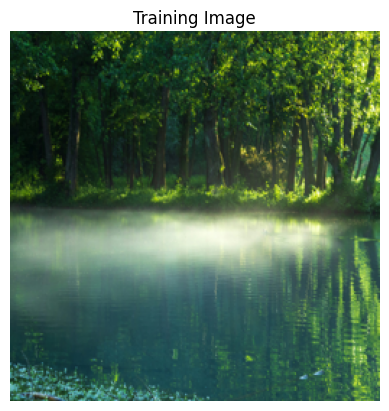

In [32]:
train_img, h, w = load_image("image.jpg")
plt.imshow(train_img)
plt.title("Training Image")
plt.axis("off")
plt.show()

In [33]:
train_feats_np = build_features(train_img, spatial_weight=0.4)
N, D = train_feats_np.shape

train_feats_tf = tf.constant(train_feats_np, dtype=tf.float32)
print("Training samples:", N)

Training samples: 65536


In [34]:
K = 10          # number of segments
ITER = 25      # number of K-means steps

# Randomly initialize cluster centers
indices = tf.random.shuffle(tf.range(N))[:K]
centers = tf.gather(train_feats_tf, indices)

def kmeans_step(points, centers):
    p_exp = tf.expand_dims(points, 1)
    c_exp = tf.expand_dims(centers, 0)
    dists = tf.reduce_sum((p_exp - c_exp)**2, axis=2)

    labels = tf.argmin(dists, axis=1, output_type=tf.int32)

    new_centers = []
    for k in range(K):
        mask = tf.equal(labels, k)
        assigned = tf.boolean_mask(points, mask)
        if tf.shape(assigned)[0] > 0:
            new_centers.append(tf.reduce_mean(assigned, axis=0))
        else:
            new_centers.append(centers[k])
    return labels, tf.stack(new_centers)

for i in range(ITER):
    labels, centers = kmeans_step(train_feats_tf, centers)
    print(f"Training iteration {i+1}/{ITER} complete")

centers_learned = centers
train_labels_final = labels

Training iteration 1/25 complete
Training iteration 2/25 complete
Training iteration 3/25 complete
Training iteration 4/25 complete
Training iteration 5/25 complete
Training iteration 6/25 complete
Training iteration 7/25 complete
Training iteration 8/25 complete
Training iteration 9/25 complete
Training iteration 10/25 complete
Training iteration 11/25 complete
Training iteration 12/25 complete
Training iteration 13/25 complete
Training iteration 14/25 complete
Training iteration 15/25 complete
Training iteration 16/25 complete
Training iteration 17/25 complete
Training iteration 18/25 complete
Training iteration 19/25 complete
Training iteration 20/25 complete
Training iteration 21/25 complete
Training iteration 22/25 complete
Training iteration 23/25 complete
Training iteration 24/25 complete
Training iteration 25/25 complete


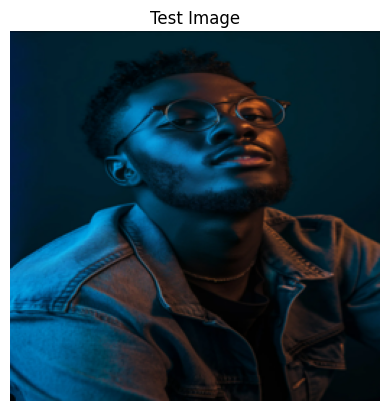

In [35]:
## Test Phase
test_img, h2, w2 = load_image("test_image.png")
plt.imshow(test_img)
plt.title("Test Image")
plt.axis("off")
plt.show()

In [36]:
test_feats_np = build_features(test_img, spatial_weight=0.4)
test_feats_tf = tf.constant(test_feats_np, dtype=tf.float32)

In [37]:
p_exp = tf.expand_dims(test_feats_tf, 1)
c_exp = tf.expand_dims(centers_learned, 0)
dists = tf.reduce_sum((p_exp - c_exp) ** 2, axis=2)

test_labels = tf.argmin(dists, axis=1, output_type=tf.int32)
test_labels_np = test_labels.numpy().reshape(h2, w2)

In [38]:
rng = np.random.default_rng(1)
colors = rng.integers(0, 255, size=(K, 3), dtype=np.uint8)

segmented = colors[test_labels_np]

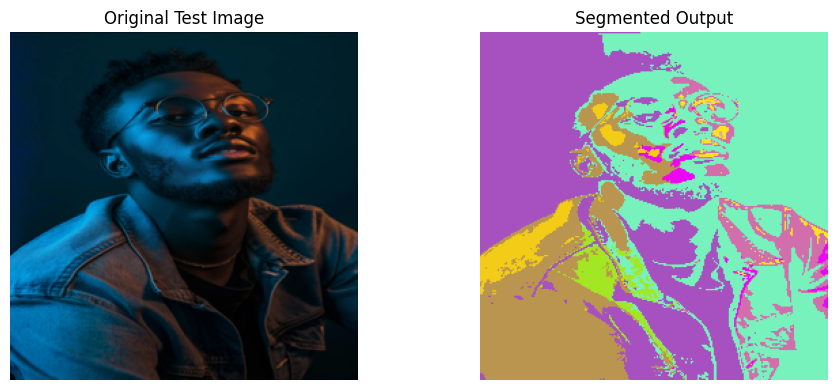

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title("Original Test Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(segmented)
plt.title("Segmented Output")
plt.axis("off")

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import silhouette_score
import numpy as np

# ---- TRAIN SILHOUETTE ----
train_labels_np = train_labels_final.numpy()

N_train = train_feats_np.shape[0]
max_samples = 5000

if N_train > max_samples:
    idx = np.random.choice(N_train, size=max_samples, replace=False)
    train_feats_sample = train_feats_np[idx]
    train_labels_sample = train_labels_np[idx]
else:
    train_feats_sample = train_feats_np
    train_labels_sample = train_labels_np

train_silhouette = silhouette_score(train_feats_sample, train_labels_sample)
print("Silhouette score on TRAIN image:", train_silhouette)


# ---- TEST SILHOUETTE ----
test_labels_np = test_labels.numpy()

N_test = test_feats_np.shape[0]
if N_test > max_samples:
    idx = np.random.choice(N_test, size=max_samples, replace=False)
    test_feats_sample = test_feats_np[idx]
    test_labels_sample = test_labels_np[idx]
else:
    test_feats_sample = test_feats_np
    test_labels_sample = test_labels_np

test_silhouette = silhouette_score(test_feats_sample, test_labels_sample)
print("Silhouette score on TEST image:", test_silhouette)


# ---- Summary Output ----
print("========== Silhouette Score Summary ==========")
print("Training:", train_silhouette)
print("Testing :", test_silhouette)
print("==============================================")

Silhouette score on TRAIN image: 0.31800944
Silhouette score on TEST image: 0.16234064
========== Silhouette Score Summary ==========
Training: 0.31800944
Testing : 0.16234064


In [41]:
# Run this AFTER you have train_feats_np and test_feats_np

from sklearn.metrics import silhouette_score
import numpy as np
import tensorflow as tf

def run_kmeans_experiment(K, num_iters=25, spatial_weight_desc=None, max_samples=5000):
    """
    Trains K-means on train_feats_np, applies to test_feats_np,
    and returns (train_silhouette, test_silhouette).
    """
    # Convert to TF tensors
    train_feats_tf = tf.constant(train_feats_np, dtype=tf.float32)
    test_feats_tf  = tf.constant(test_feats_np,  dtype=tf.float32)

    N_train = train_feats_np.shape[0]
    N_test  = test_feats_np.shape[0]
    D = train_feats_np.shape[1]

    # --- initialise centers from training points ---
    indices = tf.random.shuffle(tf.range(N_train))[:K]
    centers = tf.gather(train_feats_tf, indices)

    def kmeans_step(points, centers):
        p = tf.expand_dims(points, 1)   # [N, 1, D]
        c = tf.expand_dims(centers, 0)  # [1, K, D]
        dists = tf.reduce_sum((p - c) ** 2, axis=2)
        labels = tf.argmin(dists, axis=1, output_type=tf.int32)

        new_centers = []
        for k in range(K):
            mask = tf.equal(labels, k)
            assigned = tf.boolean_mask(points, mask)
            if tf.shape(assigned)[0] > 0:
                new_centers.append(tf.reduce_mean(assigned, axis=0))
            else:
                new_centers.append(centers[k])
        return labels, tf.stack(new_centers)

    # --- train on TRAIN image ---
    for _ in range(num_iters):
        train_labels, centers = kmeans_step(train_feats_tf, centers)

    # --- silhouette on TRAIN ---
    train_labels_np = train_labels.numpy()
    if N_train > max_samples:
        idx = np.random.choice(N_train, size=max_samples, replace=False)
        train_feats_sample = train_feats_np[idx]
        train_labels_sample = train_labels_np[idx]
    else:
        train_feats_sample = train_feats_np
        train_labels_sample = train_labels_np

    train_sil = silhouette_score(train_feats_sample, train_labels_sample)

    # --- apply learned centers to TEST image ---
    p = tf.expand_dims(test_feats_tf, 1)
    c = tf.expand_dims(centers, 0)
    dists = tf.reduce_sum((p - c) ** 2, axis=2)
    test_labels = tf.argmin(dists, axis=1, output_type=tf.int32)

    # --- silhouette on TEST ---
    test_labels_np = test_labels.numpy()
    if N_test > max_samples:
        idx = np.random.choice(N_test, size=max_samples, replace=False)
        test_feats_sample = test_feats_np[idx]
        test_labels_sample = test_labels_np[idx]
    else:
        test_feats_sample = test_feats_np
        test_labels_sample = test_labels_np

    test_sil = silhouette_score(test_feats_sample, test_labels_sample)

    return train_sil, test_sil


In [42]:
# List of K values you want to test
K_values = [3, 5, 6, 8, 10]

results = []

for K in K_values:
    print(f"\n=== Running experiment for K = {K} ===")
    train_sil, test_sil = run_kmeans_experiment(K)
    results.append((K, train_sil, test_sil))
    print(f"Train silhouette: {train_sil:.4f}")
    print(f"Test  silhouette: {test_sil:.4f}")

print("\n===== Summary table (K, train, test) =====")
for K, tr, te in results:
    print(f"K = {K:2d} | Train = {tr:.4f} | Test = {te:.4f}")



=== Running experiment for K = 3 ===
Train silhouette: 0.3844
Test  silhouette: 0.4637

=== Running experiment for K = 5 ===
Train silhouette: 0.3646
Test  silhouette: 0.2408

=== Running experiment for K = 6 ===
Train silhouette: 0.3762
Test  silhouette: 0.1669

=== Running experiment for K = 8 ===
Train silhouette: 0.3388
Test  silhouette: 0.1850

=== Running experiment for K = 10 ===
Train silhouette: 0.3130
Test  silhouette: 0.1492

===== Summary table (K, train, test) =====
K =  3 | Train = 0.3844 | Test = 0.4637
K =  5 | Train = 0.3646 | Test = 0.2408
K =  6 | Train = 0.3762 | Test = 0.1669
K =  8 | Train = 0.3388 | Test = 0.1850
K = 10 | Train = 0.3130 | Test = 0.1492


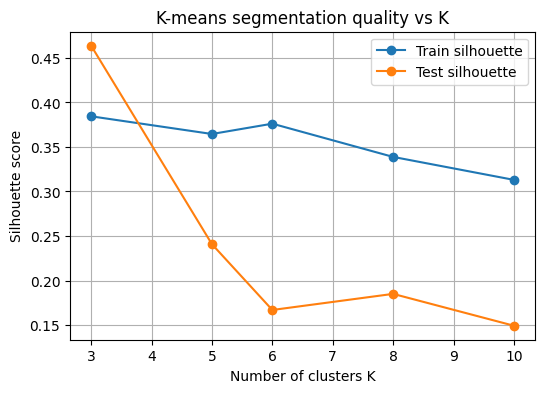

In [43]:
import matplotlib.pyplot as plt

Ks = [r[0] for r in results]
train_scores = [r[1] for r in results]
test_scores  = [r[2] for r in results]

plt.figure(figsize=(6,4))
plt.plot(Ks, train_scores, marker="o", label="Train silhouette")
plt.plot(Ks, test_scores,  marker="o", label="Test silhouette")
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette score")
plt.title("K-means segmentation quality vs K")
plt.legend()
plt.grid(True)
plt.show()


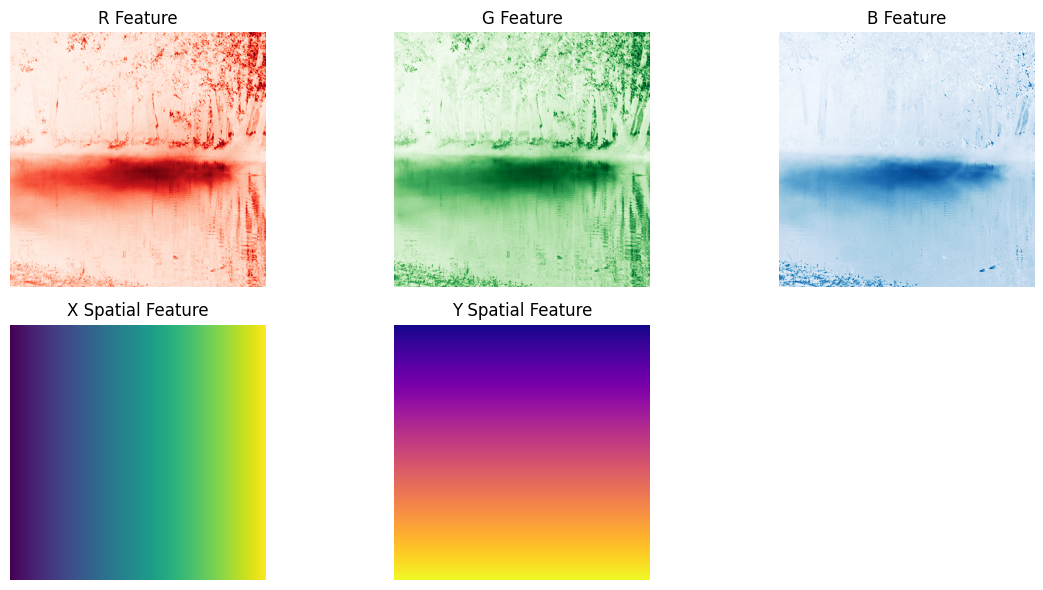

In [45]:
import matplotlib.pyplot as plt

# reshape back into image grid
R = train_feats_np[:,0].reshape(h, w)
G = train_feats_np[:,1].reshape(h, w)
B = train_feats_np[:,2].reshape(h, w)
X = train_feats_np[:,3].reshape(h, w)
Y = train_feats_np[:,4].reshape(h, w)

plt.figure(figsize=(12,6))

plt.subplot(2,3,1); plt.title("R Feature"); plt.imshow(R, cmap="Reds"); plt.axis("off")
plt.subplot(2,3,2); plt.title("G Feature"); plt.imshow(G, cmap="Greens"); plt.axis("off")
plt.subplot(2,3,3); plt.title("B Feature"); plt.imshow(B, cmap="Blues"); plt.axis("off")

plt.subplot(2,3,4); plt.title("X Spatial Feature"); plt.imshow(X, cmap="viridis"); plt.axis("off")
plt.subplot(2,3,5); plt.title("Y Spatial Feature"); plt.imshow(Y, cmap="plasma"); plt.axis("off")

plt.tight_layout()
plt.show()

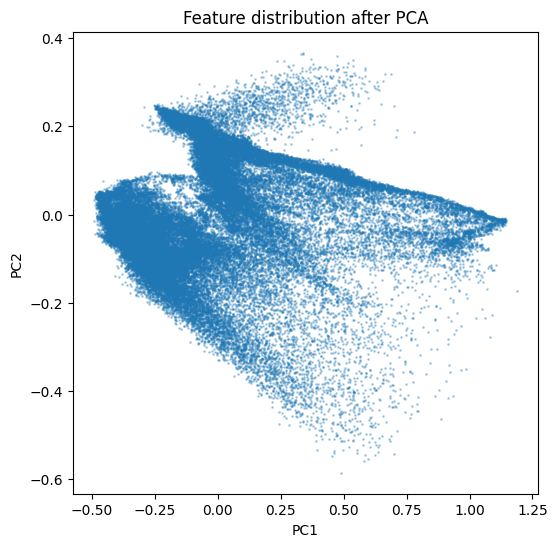

In [46]:
from sklearn.decomposition import PCA

# PCA for dimensionality reduction
pca = PCA(n_components=2)
feat_2d = pca.fit_transform(train_feats_np)

plt.figure(figsize=(6,6))
plt.scatter(feat_2d[:,0], feat_2d[:,1], s=1, alpha=0.3)
plt.title("Feature distribution after PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
